# Estimating COVID-19's $R_t$ in Real-Time for EU - results

Data and estimates from April 23. See the `Realtime R0` notebook for how numbers here were derived.

In [56]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

COUNTRIES_INCLUDED = sorted(['Austria', 'Italy', 'Belgium', 'Latvia', 'Bulgaria', 'Lithuania', 'Croatia', 'Luxembourg', 
                      'Cyprus', 'Malta', 'Czechia', 'Netherlands', 'Denmark', 'Poland', 'Estonia', 'Portugal', 
                      'Finland', 'Romania', 'France', 'Slovakia', 'Germany', 'Slovenia', 'Greece', 'Spain', 
                      'Hungary', 'Sweden', 'Ireland', 'Russia', 'Norway', 'Switzerland'])

%config InlineBackend.figure_format = 'retina'

In [57]:
def plot_rt(result, ax, country_name, scatter_alpha=1.0):
    
    ax.set_title(f"{country_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['median'].index.get_level_values('date')
    values = result['median'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               alpha=scatter_alpha,
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['lower_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['upper_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 2.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

In [58]:
final_results = pd.read_csv('data/rt_mcmc.csv',
                            parse_dates=['date'],infer_datetime_format=True,
                            index_col=['region', 'date'],
                            squeeze=True)

In [59]:
final_results

mean    median  lower_90  upper_90  lower_50  upper_50
region  date                                                                  
Austria 2020-02-16  1.571781  1.514451  1.091566  2.021277  1.264349  1.634901
        2020-02-17  1.578544  1.523626  1.121907  2.041672  1.281140  1.643232
        2020-02-18  1.583901  1.525764  1.126932  2.055658  1.276741  1.641167
        2020-02-19  1.591984  1.540524  1.122670  2.061080  1.303509  1.666134
        2020-02-20  1.597379  1.543823  1.131302  2.048508  1.257923  1.618023
...                      ...       ...       ...       ...       ...       ...
Ireland 2020-06-03  0.763848  0.793276  0.400244  1.118372  0.710112  0.969451
        2020-06-04  0.762536  0.790629  0.385497  1.117971  0.703838  0.970394
        2020-06-05  0.763091  0.791515  0.377244  1.134038  0.712208  0.982734
        2020-06-06  0.763346  0.796240  0.368099  1.140305  0.703018  0.977964
        2020-06-07  0.763489  0.795544  0.362497  1.162155  0.699691  0.979151

[3616 rows x 6 columns]

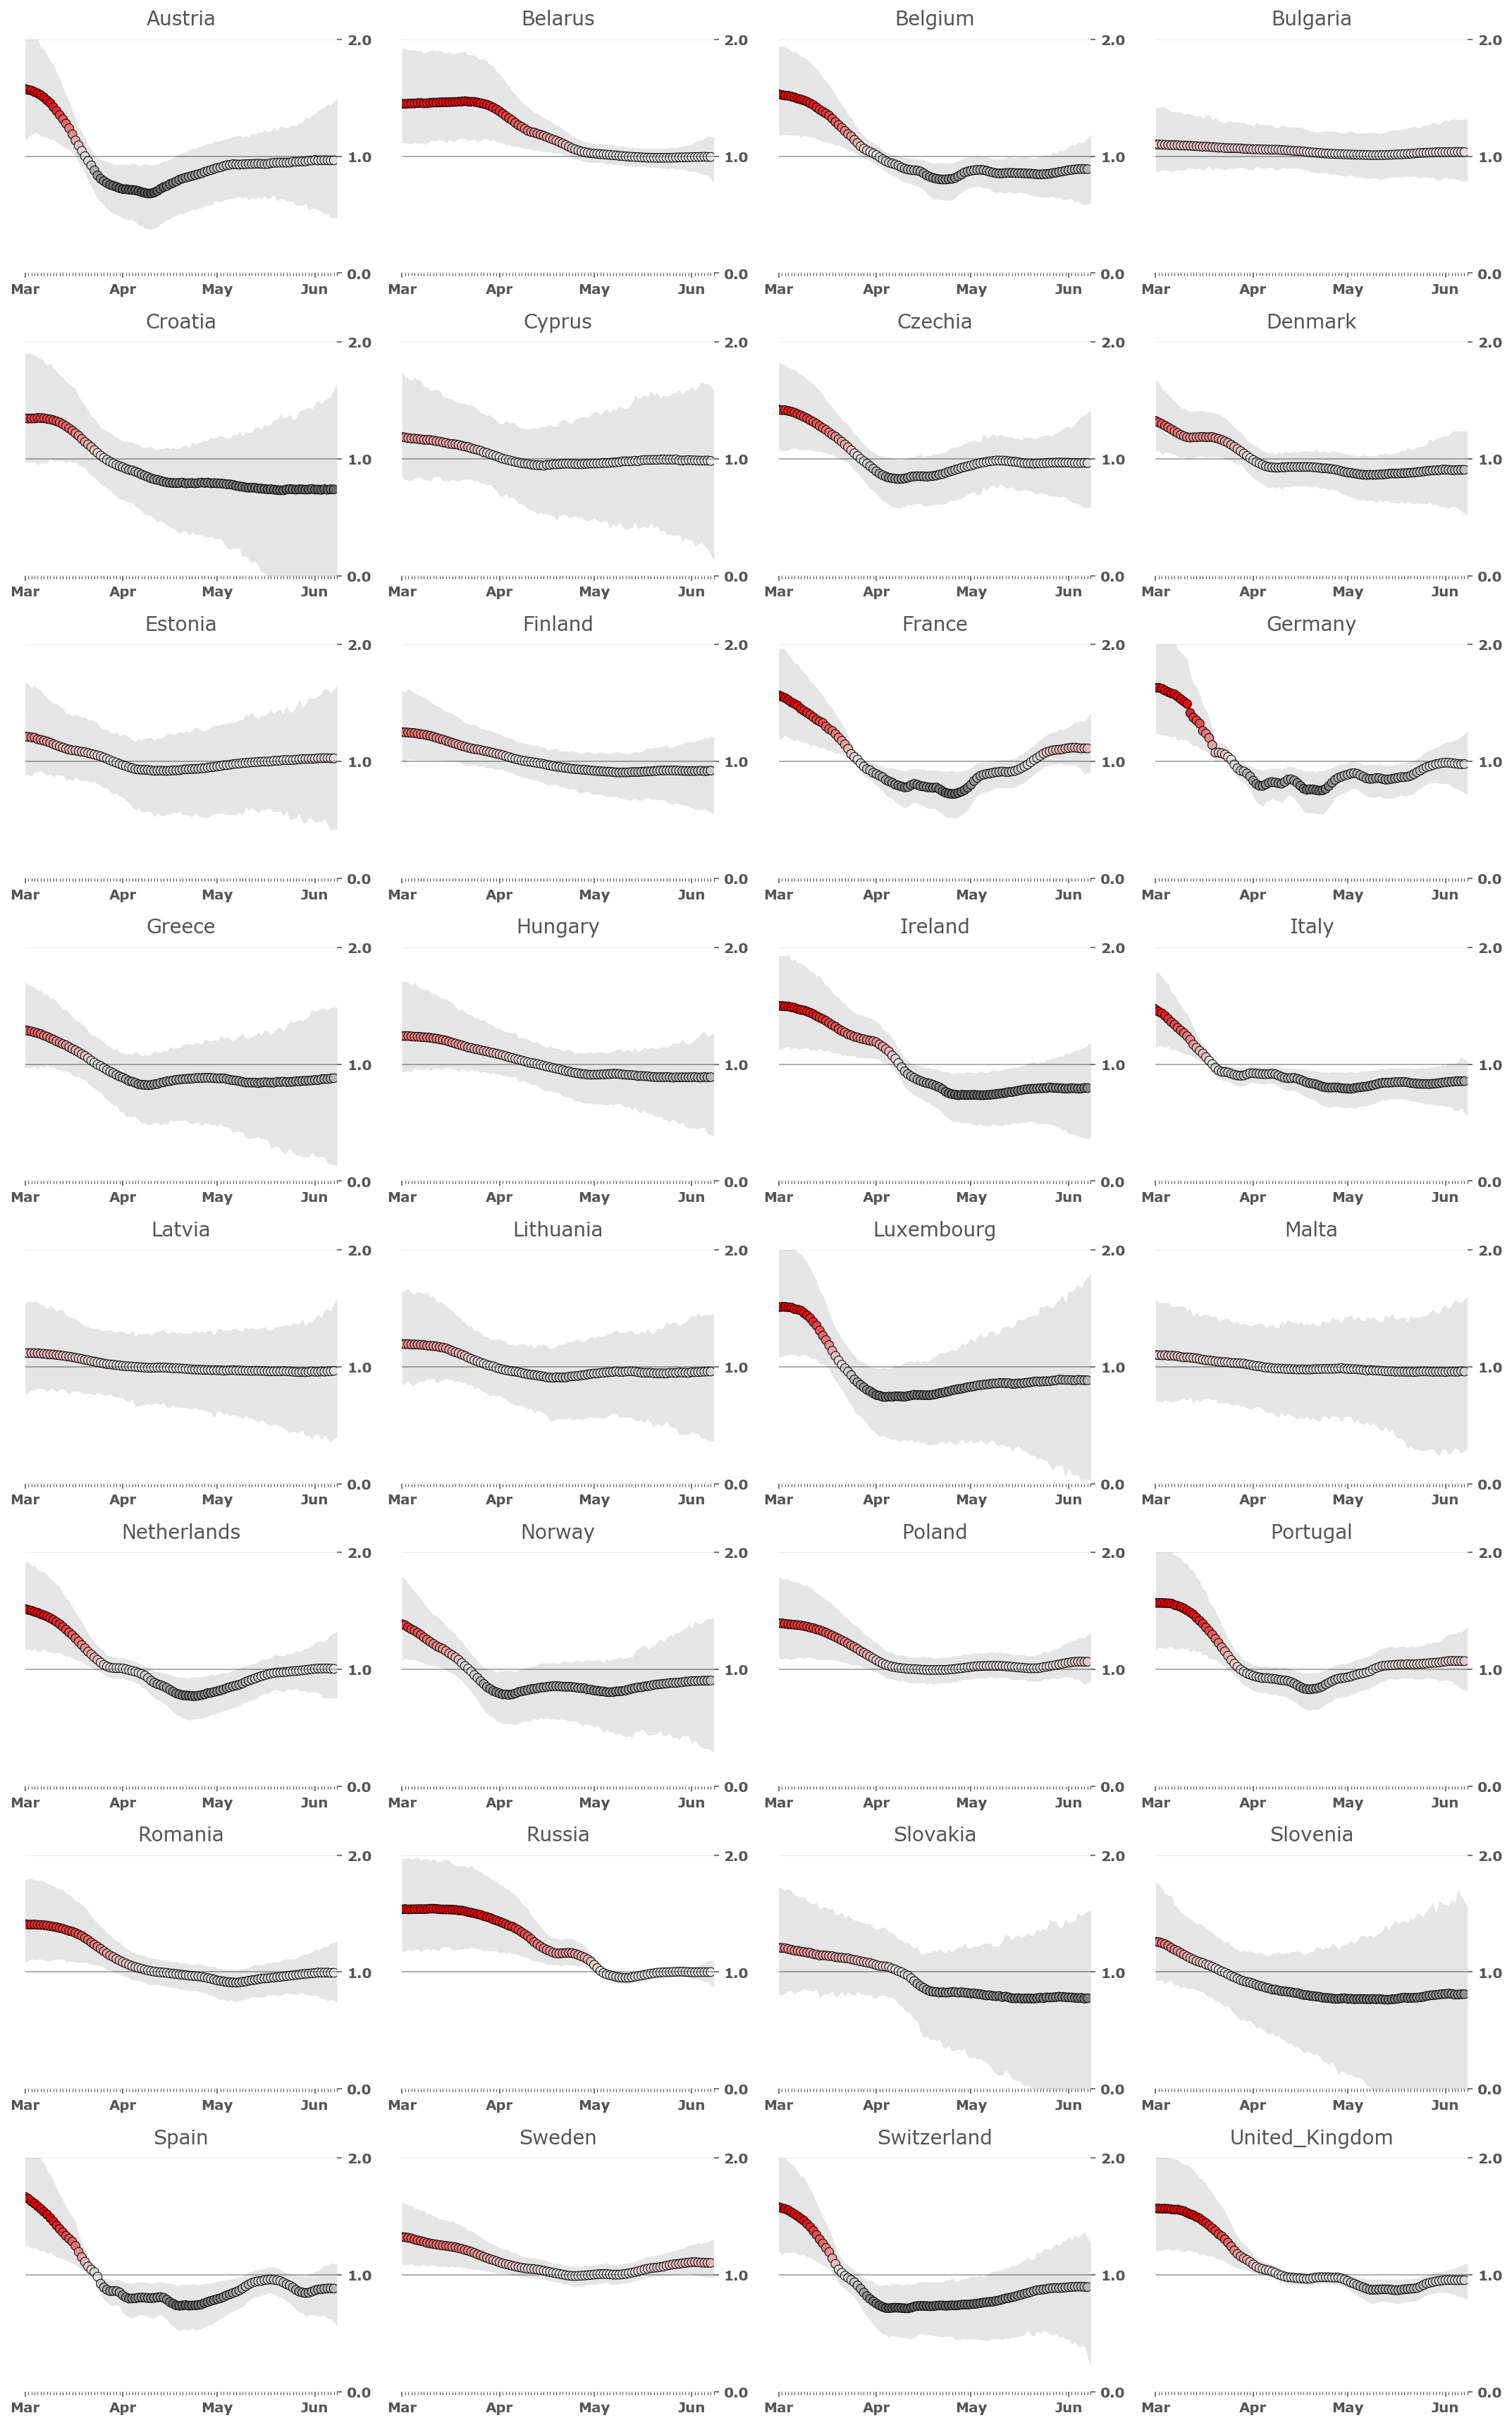

In [60]:
ncountries = len(final_results.index.unique(level='region'))
ncols = 4
nrows = int(np.ceil(ncountries / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (country_name, result) in enumerate(final_results.groupby('region')):
    plot_rt(result.iloc[1:], axes.flat[i], country_name)

fig.tight_layout()
fig.set_facecolor('w')

## Standings

In [61]:
FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]

In [62]:
no_lockdown = []
partial_lockdown = []

In [63]:
def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by Country'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['lower_90', 'upper_90']].sub(mr['median'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['median'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)
    
    too_uncertain = mr.index[(mr['upper_90'] - mr['lower_90']) > 1.2]

    for bar, country_name in zip(bars, mr.index):
        if country_name in no_lockdown:
            bar.set_color(NONE_COLOR)
        if country_name in partial_lockdown:
            bar.set_color(PARTIAL_COLOR)
        if country_name in too_uncertain:
            bar.set_alpha(0.3)

    labels = mr.index.to_series().replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)
    
    if not too_uncertain.empty:
        leg = ax.legend(handles=[
                    Patch(label='Insufficient data or an end of epidemy', color=FULL_COLOR, alpha=0.3),
                ],
#                 title='Lockdown',
#                 ncol=3,
                loc='upper left',
                columnspacing=.75,
                handletextpad=.5,
                handlelength=1)
        leg._legend_box.align = "left"

        
    fig.set_facecolor('w')
    return fig, ax

               median  upper_90  lower_90
region                                   
Austria      0.966074  1.464796  0.475385
Belgium      0.889812  1.159058  0.590488
Bulgaria     1.035865  1.315752  0.786257
Croatia      0.738495  1.589683 -0.229295
Cyprus       0.982557  1.617478  0.181387
Czechia      0.964664  1.394904  0.584610
Denmark      0.906456  1.239508  0.535144
Estonia      1.026587  1.620749  0.419874
Finland      0.922208  1.208984  0.566661
France       1.112152  1.378202  0.901767
Germany      0.978341  1.234828  0.733450
Greece       0.880757  1.486674  0.138128
Hungary      0.888865  1.251934  0.397435
Ireland      0.795544  1.162155  0.362497
Italy        0.854936  1.041146  0.585231
Latvia       0.965422  1.532375  0.380704
Lithuania    0.959497  1.447716  0.365223
Luxembourg   0.884425  1.765438  0.037111
Malta        0.959448  1.575658  0.279474
Netherlands  1.004810  1.310090  0.754643
Norway       0.905197  1.436567  0.308205
Poland       1.065951  1.291019  0

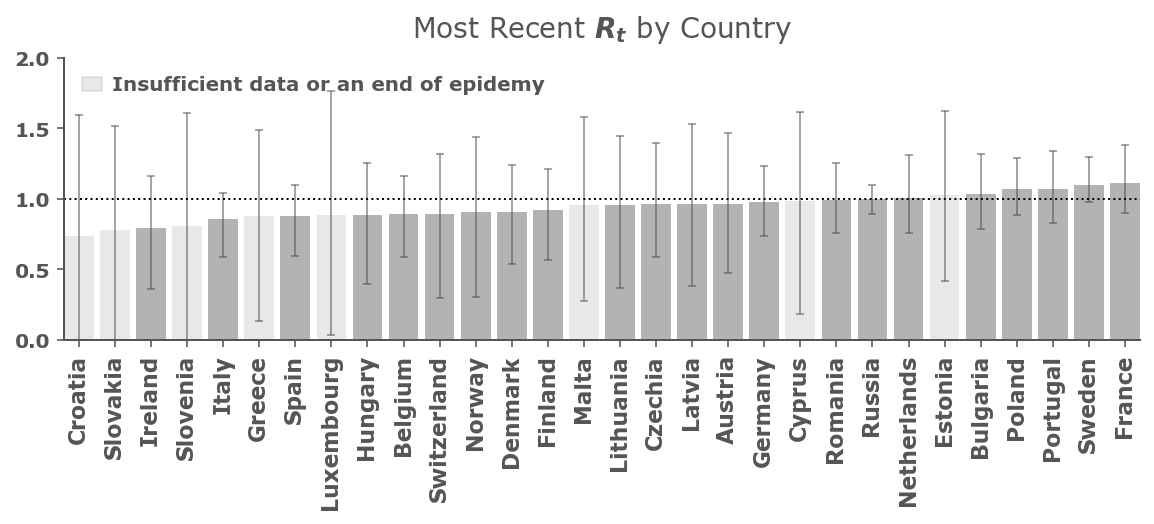

In [64]:
targets = final_results.index.get_level_values('region').isin(COUNTRIES_INCLUDED)
mr = final_results.loc[targets].groupby(level=0)[['median', 'upper_90', 'lower_90']].last()

print(mr)

mr.sort_values('median', inplace=True)
fig, ax = plot_standings(mr)

# Rainier

In [65]:
final_results_rainier = pd.read_csv('data/rt-rainier.csv',
                            parse_dates=['date'],infer_datetime_format=True,
                            index_col=['region', 'date'],
                            squeeze=True)

In [66]:
final_results_rainier

mean    median  lower_90  upper_90  lower_50  \
region         date                                                           
Austria        2020-02-06  1.628697  1.611811  1.161055  2.128157  1.413695   
               2020-02-07  1.638242  1.623812  1.202897  2.137257  1.450045   
               2020-02-08  1.647525  1.636508  1.161953  2.118240  1.451476   
               2020-02-09  1.658399  1.641703  1.189462  2.115946  1.452988   
               2020-02-10  1.662148  1.645582  1.179945  2.083270  1.495672   
...                             ...       ...       ...       ...       ...   
United_Kingdom 2020-06-03  0.953697  0.954050  0.817114  1.093121  0.903523   
               2020-06-04  0.949152  0.951821  0.799286  1.087919  0.890503   
               2020-06-05  0.952217  0.954252  0.803031  1.103605  0.895210   
               2020-06-06  0.968049  0.966618  0.811184  1.145090  0.900379   
               2020-06-07  0.968523  0.964770  0.794997  1.145802  0.870560   

                           upper_50  
region         date                  
Austria        2020-02-06  1.777861  
               2020-02-07  1.817973  
               2020-02-08  1.817075  
               2020-02-09  1.806481  
               2020-02-10  1.848532  
...                             ...  
United_Kingdom 2020-06-03  1.018683  
               2020-06-04  1.010274  
               2020-06-05  1.014747  
               2020-06-06  1.041668  
               2020-06-07  1.020960  

[3762 rows x 6 columns]

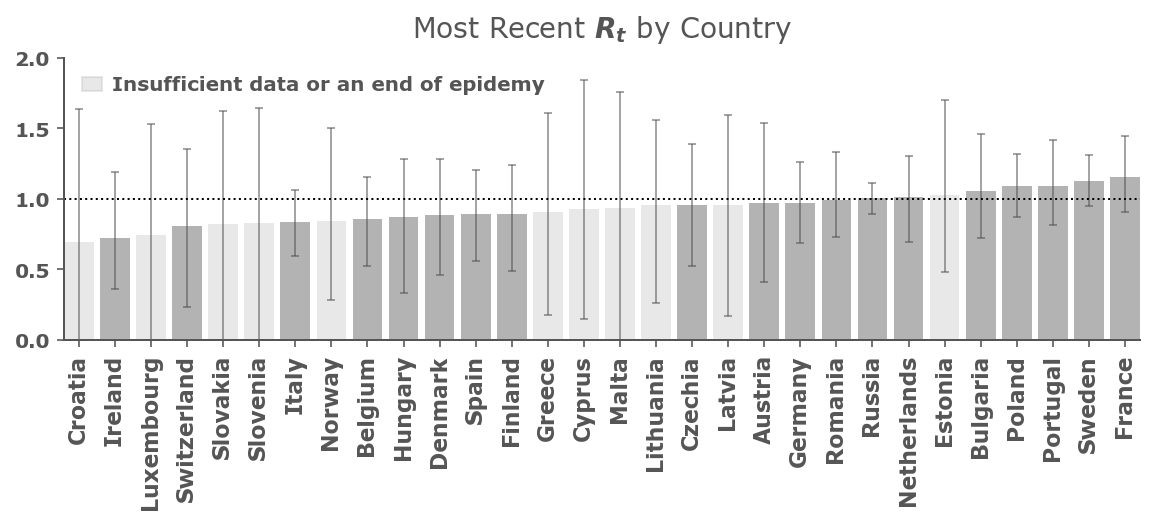

In [67]:
targets_rainier = final_results_rainier.index.get_level_values('region').isin(COUNTRIES_INCLUDED)
mr_rainier = final_results_rainier.loc[targets_rainier].groupby(level=0)[['median', 'upper_90', 'lower_90']].last()

mr_rainier.sort_values('median', inplace=True)
fig, ax = plot_standings(mr_rainier)

## Compare PYMC3's and Rainier's estimates for European countries

In [ ]:
ncountries = len(final_results_rainier.index.unique(level='region'))
ncols = 4
nrows = int(np.ceil(ncountries / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (country_name, result) in enumerate(final_results_rainier.groupby('region')):
    plot_rt(result.iloc[1:], axes.flat[i], country_name)
for i, (country_name, result) in enumerate(final_results.groupby('region')):
    plot_rt(result.iloc[1:], axes.flat[i], country_name)

    
#for i, (country_name, result) in enumerate(final_results.groupby('country')):
#    plot_rt(result.iloc[1:], axes.flat[i], country_name, scatter_alpha=0.25)

fig.tight_layout()
fig.set_facecolor('w')